# Lumia Library

In [1]:
class Lumia():
    
    def __init__(self, dados={},heat_rate=[],pre_heat=False):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        self.data = dados
        self.pre_heat = pre_heat
        self.heat_rate = heat_rate
    #_______________________________________________________________________________________________________________

    def load_TL(self, arquivo,pre_heat=False, pre_heat_value=25, points_equal_temp=True,trimm_by='\t', lim_init = 4):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        with open(arquivo, 'r') as f:#Abre arquivo
            matrix = [[item for item in line.split(trimm_by)] for line in f.readlines()[lim_init:-1]]#Quebra linhas e colunas por tabulação
        matrixNumpy = np.array(matrix)                #matriz numpy
        curve={}                                     #variavel dicionario auxiliar
        for i in range(len(matrixNumpy.T)):       #É a iteração nas colunas pelo intervalo da matrix transposta do resultado
            lab=matrixNumpy[:,i]               #seleciona a coluna toda
            lista=[]                         #lista auxiliar
            for lin in lab:                   #iteração de valor em valor
                try:                         #evita bugs e erros por conversão falha
                    lista.append(int(lin))      #converte str para int
                except:
                    lista.append(np.nan)      #caso vazio e erro adiciona NAN
            if i == 0:                        #a primeira coluna é temperatura
                if pre_heat == False:          #Teste logico de preheat para soma de Temperatura inicial
                    curve.setdefault('Temperatura',lista) #Adciona o rótulo temperatura ao dicionario
                else:
                    lista = np.array(lista) + pre_heat_value #soma o preheat em um nd array
                    lista = list(lista)
                    curve.setdefault('Temperatura',lista) #adiciona a temperatura ao dicinario
            else:
                curve.setdefault('Curva {0}'.format(i),lista) #Adiciona as curvas ao dicionario
        data=pd.DataFrame(curve, index=curve['Temperatura']) #cria um pd.dataframe com os resultados
        self.data = data
        return data
    
        #_______________________________________________________________________________________________________________
    def add_data(self,arquivo):
        self.data = arquivo
        
         #______________________________________________________________________________________________________________
    def init_rise_prep(self,curva,lim_init=80,lim_fin=250,sig=0.07, npontos=13, pre_heat_val=25):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        pre_heat = self.pre_heat
    #variaveis importantes    
        k=0.00008617333262145                       #constante de bolzmann
                 #Diminuição do dataframe
        objeto = self.data[curva]
        curva1 = objeto[lim_init:lim_fin]            #Fatia o dataframe no intervalo de interesse
        limite = curva1.cumsum()                        #Determinação dos limites
        tol = limite[max(limite.index)]*sig            #Tolerância para seção do dataset
        atol = []                                     #lista vazia a ser preenchida com valores de intensidade TL
        index = []                                   #índice padrão
        temp = []                                  #temperatura em kelvin
    
        for it,num,cur in zip(limite,limite.index,curva1):
            if it < tol:
                atol.append(cur)
                temp.append(num+273)
                index.append(num)
        if pre_heat == True:
            temp = np.array(temp) + pre_heat_val
        else:
            pass 
        lim_temp = max(index)
        int_val = lim_temp - npontos #Seleciona 14 pontos
        diff = int_val-lim_init 
        Frame = pd.DataFrame()
        Frame['Temperatura (K)'] = temp
        Frame['TL'] = atol
        Frame['ln(TL)'] = np.log(atol)
        Frame['1/kt'] = 1/(k*Frame['Temperatura (K)'])
        Frame.index=index
        Frame= Frame[:][diff:]
        return Frame
    
        #_______________________________________________________________________________________________________________

    def init_rise_result(prepared_data):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        x = np.array(prepared_data['1/kt'])
        y = np.array(prepared_data['ln(TL)'])
        from scipy.stats import linregress
        lin_reg = linregress(x,y)
        ea = -1*lin_reg.slope
        answer = {'Parametros present':{'Energia de Ativação':'{0}  ± {1} eV'.format(ea, lin_reg.stderr),'r^2':lin_reg.rvalue},
                 'Parametros Calc':{'Energia de Ativação':ea,'incerteza':lin_reg.stderr}}
    
        answerdb = {'Energia de Ativação':ea,'incerteza':lin_reg.stderr, 'r^2':lin_reg.rvalue}
        return answerdb
    
        #_______________________________________________________________________________________________________________

    def extract_ir(self):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        resposta = {'EA_IR(eV)':[],'error_ir':[],'r^2_ir':[],'objeto':[]}#conjunto resposta
        colunas = list(self.data.columns)
        colunas = colunas[1:]
        objeto = self.data
        for coluna in colunas:
            
            dados = self.init_rise_prep(curva=coluna)                #função de preparação
            answer = Lumia.init_rise_result(dados)                    #função de regressão
            resposta['EA_IR(eV)'] += [answer['Energia de Ativação']]#adição da resposta
            resposta['error_ir'] += [answer['incerteza']]       #adição da resposta
            resposta['r^2_ir'] += [answer['r^2']]               #adição da resposta
            resposta['objeto'] += [coluna]                      #adição da resposta
        return pd.DataFrame(resposta,index=resposta['objeto'])
    
    #_______________________________________________________________________________________________________________
    def area_met_prep(self,curva,heat_rate, kin_order, lim_init=80,lim_fin=150,deltaT=1):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        objeto = self.data[curva]
        pre_heat= self.pre_heat
        if heat_rate > 6:
            lim_init=135 
            lim_fin=240 
        elif heat_rate ==6:
            lim_init=120
            lim_fin=220
        elif heat_rate == 5:
            lim_init=120
            lim_fin=220
        elif (heat_rate < 5) & (heat_rate>2):
            lim_init= 130
            lim_fin=  210
        elif heat_rate == 2:
            lim_init= 100
            lim_fin=  200
        elif heat_rate == 1:
            lim_init= 95
            lim_fin=  185
        elif heat_rate == 0.9:
            lim_init=95
            lim_fin= 190
        elif heat_rate == 0.8:
            lim_init=95
            lim_fin= 190
        elif heat_rate == 0.7:
            lim_init=90
            lim_fin=180
        elif (heat_rate < 0.7) & (heat_rate > 0.4):
            lim_init=90
            lim_fin=175
        elif (heat_rate == 0.4):
            lim_init=85
            lim_fin=170
        elif (heat_rate == 0.3):
            lim_init=85
            lim_fin=170
        
        elif (heat_rate == 0.2) | (heat_rate == 0.1):
            lim_init=80
            lim_fin=160
        k=0.00008617333262145
        y = np.array(objeto[lim_init:lim_fin])
        x = np.array(objeto[lim_init:lim_fin].index)
        temp = x+273     #converte a temperatura para kelvin
        preview = pd.DataFrame()
        if pre_heat == True:
            temp+=25
        else:
            pass
        preview['Temperatura (K)'] = temp
        preview['TL'] = y
        preview.set_index(x, inplace=True)
        area=[]
        for i in range(len(y)):
            area.append((max(y[i:len(y)].cumsum()))*(deltaT/heat_rate))
        np.array(area)
        preview['area'] = area
        preview['1/kt'] =  1/(k*preview['Temperatura (K)'])
        preview['ln(TL/area)'] = np.log(preview.TL/preview.area)
        preview['hr'] = [heat_rate]*len(area)
        for ko in kin_order:
            pr = np.array(np.log(preview.TL/(preview.area)**ko))
            preview = dict(preview)
            preview.setdefault('b= {0}'.format(ko), pr)
            preview = pd.DataFrame(preview)
            self.area_result = preview
        return preview
       #_______________________________________________________________________________________________________________

 
        #_______________________________________________________________________________________________________________
    def area_result(prepared_data, heat_rate):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        import math
        from scipy.stats import linregress
    
        x = np.array(prepared_data['1/kt'])
        atr_list = list(prepared_data.columns)
        atr_list = atr_list[4:]
        r_squared = {}
    
        for atributo in atr_list:
            y=np.array(prepared_data[atributo])
            lin_reg = linregress(x,y)
            r_squared.setdefault(atributo,-1*lin_reg.rvalue)
        best = max(r_squared)
        y=np.array(prepared_data[best])
        lin_reg = linregress(x,y)
        ea = -1*lin_reg.slope
        escape_factor = heat_rate*math.exp(-lin_reg.intercept)
        escape_error = lin_reg.intercept_stderr * escape_factor
        percentual_error = escape_error/escape_factor
        if best == 'ln(TL/area)':
            best = 'b = 1'
        answer_present = {'Energia de Ativação':'{0}  ± {1} eV'.format(ea, lin_reg.stderr),
                      'r^2':lin_reg.rvalue,
                      'Fator de Escape':'{0} ± {1} eV'.format(escape_factor,escape_error),
                      'Erro percentual':'{0} %'.format(percentual_error*100)}
        answer_db = {'Energia de Ativação':ea,
                 'Incerteza EA':lin_reg.stderr,
                 'r^2':lin_reg.rvalue,
                 'Fator de Escape':escape_factor, 
                 'Incerteza Escape_factor':escape_error,
                 'Percentual Error':percentual_error,
                 'Best_kin_order':best}                       
        return answer_present, answer_db
    
        #_______________________________________________________________________________________________________________


    def extract_area(self,heat_rate,test_kin_order):#informar uma lista com todas as taxas de aquecimento do DB
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        pre_heat = self.pre_heat
        resposta = {'EA_AREA(eV)':[],'error_AREA':[],'r^2_AREA':[],'freq_factor_AREA':[],
                    'ff_err_AREA':[],'ff_percerr_AREA':[],'AREA_kin_order':[],'objeto':[], 
                    'Taxa de aquecimento':[]} #conjunto resposta
        colunas = list(self.data.columns)
        colunas = colunas[1:]
        for coluna, hr in zip(colunas, heat_rate):
            dados = self.area_met_prep(coluna,hr, test_kin_order)                #função de preparação
            answer_pres, answer = Lumia.area_result(dados,hr)                    #função de regressão
            resposta['EA_AREA(eV)'] += [answer['Energia de Ativação']]#adição da resposta
            resposta['error_AREA'] += [answer['Incerteza EA']]       #adição da resposta
            resposta['r^2_AREA'] += [answer['r^2']]               #adição da resposta
            resposta['freq_factor_AREA'] += [answer['Fator de Escape']]
            resposta['ff_err_AREA'] += [answer['Incerteza Escape_factor']]
            resposta['ff_percerr_AREA'] += [answer['Percentual Error']]
            resposta['AREA_kin_order'] += [answer['Best_kin_order']]
            resposta['Taxa de aquecimento'] += [hr]
            resposta['objeto'] += [coluna]                      #adição da resposta
        return pd.DataFrame(resposta,index=resposta['objeto'])
    
    #_______________________________________________________________________________________________________________

    def peak_shape_met(curva,DeltaT=1,error=0.5, ph_val=25, pre_heat=False):
    #Encontrar a posição do pico
        peak = curva.max()

    #Encontrar o índice (Temperatura) do pico:

        j=0
        for i in curva:
            if i == peak:
                tmax = j*DeltaT
                break
            else:
                j+=1

    #Meia Altura
        half_peak = peak/2
    #Divisão do Dataset em dois
        t1_cand = np.array(curva[:tmax]) #Para T1
        t2_cand = np.array(curva[tmax:]) #Para T2

    #################################################################################################################

    #Testes lógicos para encontrar os índex respectivos
    # Fração inferior ao pico
        j=0
        for cand1 in t1_cand:
            if cand1 < half_peak:
                j0=j
                j+=1
            else:
                j2 = j0+1
                j+= 1
                continue
    # O j não reseta entre as iterações de t1_cand para t2_cand

    # Fração superior ao pico
        for cand2 in t2_cand:
            if cand2 > half_peak:
                j1=j
                j+=1
            else:
                j3 = j1+1
                break

    #Obtenção de T1 e transformação de ponto para temperatura
        if (half_peak - curva[j0]) < (curva[j2] - half_peak):
            t1 = j0 * DeltaT
        else:
            t1 = j2 * DeltaT
    #Obtenção de T2  
        if (curva[j1] - half_peak) < (half_peak - curva[j3]):
            t2 = j1 * DeltaT
        else:
            t2 = j3 * DeltaT
    ########################################################################################################################    

    # para kelvin
        t1 += 273
        t2 += 273
        tmax += 273
        k=0.00008617333262145
        
        if pre_heat == True:
            t1 += ph_val
            t2 += ph_val
            tmax += ph_val
        else:
            pass
    # Calculo dos parâmetros de forma
        delta = t2 - tmax
        omega = t2 - t1
        tau = tmax - t1
        shape_factor_mi = delta/omega
        shape_factor_gama = delta/tau

    #Energia de ativação

    #Omega de Chen
        omega_chen = (2.25+10.2*(shape_factor_mi - 0.42))*((k*tmax**2)/omega) - 1*(2*k*tmax)
    #Tau de Chen
        tau_chen = (1.510+3.0*(shape_factor_mi - 0.42))*((k*tmax**2)/tau) - (1.58+4.2*(shape_factor_mi - 0.42))*(2*k*tmax)
    #delta de Chen
        delta_chen = (0.976+7.3*(shape_factor_mi - 0.42))*((k*tmax**2)/delta)
    #kinetic order
        if shape_factor_mi < 0.44:
            kin_order = 'Primeira Ordem'
        elif shape_factor_mi < 0.50:
            kin_order = 'Ordem Geral'
        else:
            kin_order = 'Segunda Ordem'
    #Incertezas
    #delta
        delta_error = (2*(error/tmax) + (error/delta))*delta_chen
        mi_error = ((error/delta) + (error/omega))*shape_factor_mi
    #resposta
        answer = {'Parâmetros de forma':{'delta':'{0} K'.format(delta),'omega':'{0} K'.format(omega),'tau':'{0} K'.format(tau),
                                         'mi':'{0} ± {1}'.format(shape_factor_mi, mi_error)},
                  'Energia de Ativação':{'Delta de Chen':'{0} ± {1} eV'.format(delta_chen,delta_error),
                                         'Tau de Chen':'{0} eV'.format(tau_chen),
                                         'Omega de Chen':'{0} eV'.format(omega_chen)},
                  'Ordem Cinética':kin_order, 'Outras informações':{'TMax':'{0} K'.format(tmax),'T1':'{0} K'.format(t1),
                                                                'T2':'{0} K'.format(t2), 'IM':peak}}
        answerdb = {'Delta de Chen':delta_chen,
                    'deta_error':delta_error,
                    'Tau de Chen':tau_chen,
                    'Omega de Chen':omega_chen,
                    'Ordem Cinética':kin_order,
                    'Tmax':tmax,
                    'T1':t1,
                    'T2':t2,
                    'IM':peak,
                    'Mi':shape_factor_mi,
                    'mi_error':mi_error,
                    'delta':delta,
                    'Tau':tau,
                    'Omega':omega}
        return answer, answerdb
    
    #_______________________________________________________________________________________________________________
    def extract_pshape(self):
        pre_heat = self.pre_heat
        resposta = {'tau_chen(eV)':[],'omega_chen(eV)':[],'delta_chen(eV)':[],'delta_error':[],
                    'ordem_cinetica':[],'tmax':[],'t1':[],'t2':[],'IM':[],'Shape_factor':[],
                    'Sf_error':[],'objeto':[]} #conjunto resposta
        colunas = list(self.data.columns)
        colunas = colunas[1:]
        for coluna in colunas:              
            answer_pres, answer = Lumia.peak_shape_met(self.data[coluna],pre_heat=pre_heat)                    #função de regressão
            resposta['tau_chen(eV)'] += [answer['Tau de Chen']]#adição da resposta
            resposta['omega_chen(eV)'] += [answer['Omega de Chen']]       #adição da resposta
            resposta['delta_chen(eV)'] += [answer['Delta de Chen']]               #adição da resposta
            resposta['delta_error'] += [answer['deta_error']]       
            resposta['ordem_cinetica'] += [answer['Ordem Cinética']]          
            resposta['tmax'] += [answer['Tmax']]          
            resposta['t1'] += [answer['T1']]          
            resposta['t2'] += [answer['T2']]
            resposta['IM'] += [answer['IM']]
            resposta['Shape_factor'] += [answer['Mi']]
            resposta['Sf_error'] += [answer['mi_error']]
            resposta['objeto'] += [coluna]                      #adição da resposta
        return pd.DataFrame(resposta,index=resposta['objeto'])
    
     #_______________________________________________________________________________________________________________
    
    def multi_heating_rate_ti(curva1,curva2,heating_rate, DeltaT=1):
        pre_heat = self.pre_heat
    #Encontrar a posição do pico
        if pre_heat == True:
            pre_heat_temp=25
        else:
            pre_heat_temp=0
        k=0.00008617333262145
        curvas = [curva1,curva2] #transforma em um objeto tipo lista iteravel
        ind=0 # quando ind=0, sub index 1, quando ind=1 sub index 2
#Encontrar IM & TM de cada uma das curvas:
        for curva, hr in zip(curvas, heating_rate):
            peak = curva.max()
            j=0
            for i in curva:
                if i == peak:
                    tmax = j*DeltaT + pre_heat_temp
                    break
                else:
                    j+=1
            if ind == 0:
                tm1c = tmax
                Im1s = peak
                hr_1 = hr
                Im1 = peak/hr_1
                Tm1 = tm1c+ 273
             
            else:
                tm2c = tmax
                hr_2= hr
                Im2 = peak/hr_2
                Tm2 = tm2c + 273
            ind+=1
    #Calculo da Energia de ativação
        EA_beta = k * ((Tm1*Tm2)/(Tm1-Tm2))*np.log((hr_1/hr_2)*(Tm1/Tm2)**2)
        EA_Im = ((k*Tm1*Tm2)/(Tm1-Tm2))*np.log((Im1/Im2))
        return(EA_beta,EA_Im,Tm1,Tm2)

    #_______________________________________________________________________________________________________________
    def multi_heating_rate_prep(dataset,curvas,heating_rate, DeltaT=1,ph_val=25, pre_heat=False): 
        Df_new = {'Temperatura (C)':[], 'Temperatura (K)':[],'y':[],'x':[],'Heat_rate':[]}
        k=0.00008617333262145
        for curv, hr in zip(curvas, heating_rate):
            curva = dataset[curv]
            peak = curva.max()
            j=0
            for i in curva:
                if i == peak:
                    tmax = j*DeltaT
                    break
                else:
                    j+=1
            if pre_heat==True:
                tm1c = tmax+ph_val
            else:
                tm1c = tmax
            Tm = tm1c+ 273
            
            Df_new['Temperatura (C)'] += [tm1c]
            Df_new['Temperatura (K)'] += [Tm]
            Df_new['y'] += [np.log((Tm**2)/hr)]
            Df_new['x'] += [1/(k*Tm)]
            Df_new['Heat_rate'] += [hr]
        return pd.DataFrame(Df_new)

    #_______________________________________________________________________________________________________________
    def multi_heating_rate_reg(dados_preparados):#recebe a saída de multi_heating_rate_prep()
        from scipy.stats import linregress
        import math
        k=0.00008617333262145
        x = dados_preparados['x']
        y = dados_preparados['y']
    #Regressão Linear

        lin_reg = linregress(x,y) #Regressão
    
    #Calculo de parâmetros cinéticos

        ea = lin_reg.slope
        intercept = lin_reg.intercept
        escape_factor = ea*math.exp(intercept/k)
        escape_per_error = (lin_reg.stderr/ea) + lin_reg.intercept_stderr
        escape_error = escape_per_error * escape_factor
    
    #Resposta   
        answer_present = {'Energia de Ativação':'{0}  ± {1} eV'.format(ea, lin_reg.stderr),
                            'r^2':lin_reg.rvalue,
                          'Fator de Escape':'{0} ± {1} eV'.format(escape_factor,escape_error),
                          'Erro percentual':'{0} %'.format(escape_per_error*100)}
        answer_db = {'Energia de Ativação':ea,
                     'Incerteza EA':lin_reg.stderr,
                     'r^2':lin_reg.rvalue,
                     'Fator de Escape':escape_factor, 
                     'Incerteza Escape_factor':escape_error,
                     'Percentual Error':escape_per_error} 
        return answer_present, answer_db
    #_______________________________________________________________________________________________________________

#Entra com o conjunto de dados e uma lista com a lista de nomes das curvas de cada amostra
    def extract_mhr(self,samples,heat_rate):#informar uma lista com todas as taxas de aquecimento do DB
        resposta = {'EA_mhr(eV)':[],'error_mhr':[],'r^2_mp':[],'freq_factor_mp':[],
                    'ff_percerr_mp':[],'Amostra':[] 
                    } #conjunto resposta
        amostra = 1
        pre_heat = self.pre_heat
        for sample in samples:
        
            dados = Lumia.multi_heating_rate_prep(self.data,sample,heat_rate,pre_heat=pre_heat)               #função de preparação
            answer_pres, answer = multi_heating_rate_reg(dados)                    #função de regressão
            resposta['EA_mhr(eV)'] += [answer['Energia de Ativação']]#adição da resposta
            resposta['error_mhr'] += [answer['Incerteza EA']]       #adição da resposta
            resposta['r^2_mp'] += [answer['r^2']]               #adição da resposta
            resposta['freq_factor_mp'] += [answer['Fator de Escape']]
            resposta['ff_percerr_mp'] += [answer['Percentual Error']]
            resposta['Amostra'] += ['Amosta {0}'.format(amostra)]                      #adição da resposta
            amostra+=1
        return pd.DataFrame(resposta, index=resposta['Amostra'])

# Teste

In [2]:
#Leitura de dataset curado
import pandas as pd
import numpy as np
dados = pd.read_csv('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Resultados finais/Resultados finais.csv')
dados.pop('index')

0        0
1        1
2        2
3        3
4        4
      ... 
345    345
346    346
347    347
348    348
349    349
Name: index, Length: 350, dtype: int64

In [3]:
arquivo = Lumia(dados,pre_heat=True)

In [ ]:
#ou
arquivo = Lumia()
arquivo.add_data(dados)

In [53]:
arquivo2 = Lumia(dados)

In [29]:
arquivo2.area_met_prep(curva='Curva 11',heat_rate=10,kin_order=[1.1,1.2,1.3])

,Temperatura (K),TL,area,1/kt,ln(TL/area),hr,b= 1.1,b= 1.2,b= 1.3
135,408,22258.0,5550824.9,28.442446,-5.519000,10,-7.071946,-8.624892,-10.177837
136,409,22211.0,5548599.1,28.372905,-5.520713,10,-7.073619,-8.626524,-10.179430
137,410,22399.0,5546378.0,28.303703,-5.511884,10,-7.064750,-8.617615,-10.170481
138,411,22508.0,5544138.1,28.234837,-5.506626,10,-7.059451,-8.612276,-10.165101
139,412,23038.0,5541887.3,28.166306,-5.482945,10,-7.035730,-8.588514,-10.141299
...,...,...,...,...,...,...,...,...,...
235,508,50433.0,13773.3,22.843540,1.297914,10,0.344865,-0.608184,-1.561232
236,509,35406.0,8730.0,22.798660,1.400116,10,0.492664,-0.414788,-1.322240
237,510,24491.0,5189.4,22.753957,1.551688,10,0.696250,-0.159187,-1.014624
238,511,16373.0,2740.3,22.709429,1.787566,10,0.995984,0.204402,-0.587181


In [6]:
ir = arquivo.extract_ir()
area = arquivo.extract_area(heat_rate, [1.1,1.2,1.3,1.4])
chen = arquivo.extract_pshape()

aux = {'Método':[],'EA(eV)':[]}
aux['hr'] = heat_rate*5
aux['Método']+=['Omega']*95
aux['Método']+=['Tau']*95
aux['Método']+=['Delta']*95
aux['Método']+=['Area']*95
aux['Método']+=['IR']*95
x= list(chen['omega_chen(eV)'])
y= list(chen['tau_chen(eV)'])
z=list(chen['delta_chen(eV)'])
w=list(area['EA_AREA(eV)'])
s=list(ir['EA_IR(eV)'])
aux['EA(eV)']+= x
aux['EA(eV)']+= y
aux['EA(eV)']+= z
aux['EA(eV)']+= w
aux['EA(eV)']+= s
aux = pd.DataFrame(aux)

In [14]:
ir['Taxa de aquecimento (K/s)'] = heat_rate

In [5]:
# Montagem de das taxas de aquecimento
heat_rate_l = [[i]*5 for i in range(1,11)]
heat_rate_l2 = [0.1]*5 + [0.2]*5 + [0.3]*5 + [0.4]*5 + [0.5]*5 + [0.6]*5 + [0.7]*5 +[0.8]*5 +[0.9]*5
heat_rate=[]
for hr in heat_rate_l:
    heat_rate += hr
heat_rate = heat_rate + heat_rate_l2
heat_rate = sorted(heat_rate, reverse=True)
heat_samp = [10,9,8,7,6,5,4,3,2,1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]


In [9]:
# Onde salvar as figuras
import matplotlib.pyplot as plt
PROJECT_ROOT_DIR = r'C:\Users\André Tavares\Desktop'
CHAPTER_ID = "training_linear_models"
import os
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

c:\users\andré tavares\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Saving figure Distribuição de Resposta


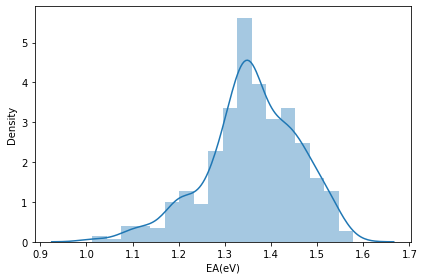

In [10]:
import seaborn as sns
sns.distplot(aux["EA(eV)"])
save_fig('Distribuição de Resposta')

c:\users\andré tavares\appdata\local\programs\python\python38\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


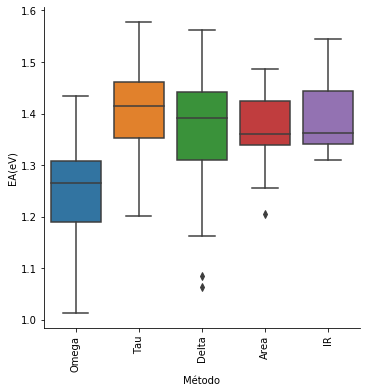

In [11]:
Summary = sns.factorplot(y='EA(eV)',x='Método', kind='box', data=aux)
plt.xticks(rotation=90)
Summary.savefig('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Resultados finais/E por método.png')

c:\users\andré tavares\appdata\local\programs\python\python38\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


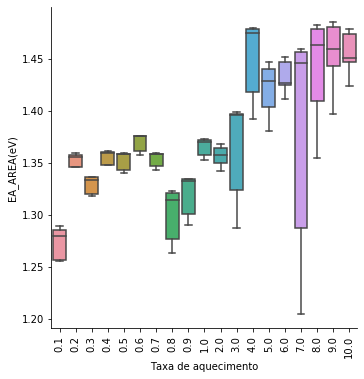

In [12]:
sing = sns.factorplot(x='Taxa de aquecimento',y='EA_AREA(eV)', kind='box', data=area)
plt.xticks(rotation=90)
sing.savefig('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Resultados finais/area_dist.png')

c:\users\andré tavares\appdata\local\programs\python\python38\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


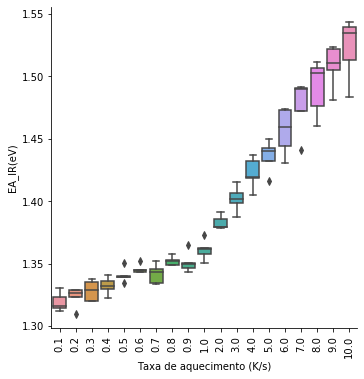

In [15]:
sing = sns.factorplot(x='Taxa de aquecimento (K/s)',y='EA_IR(eV)', kind='box', data=ir)
plt.xticks(rotation=90)
sing.savefig('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Resultados finais/ir_dist.png')

In [21]:
medias = pd.DataFrame()
medias['EA_ir'] = ir['EA_IR(eV)'] 
medias['ir_error'] = ir.error_ir

In [17]:
ir['EA_IR(eV)'].median()

1.3625416101823804

In [23]:
chen.to_csv('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Resultados finais/chen.csv')

In [22]:
medias['EA_area'] = area['EA_AREA(eV)']
medias['area_error'] = area.error_AREA
medias['freq_factor_area'] = area.freq_factor_AREA
medias['ff_ee_AREA'] = area.ff_err_AREA
medias['hr'] = area['Taxa de aquecimento']

In [23]:
medias['delta_chen'] = chen['delta_chen(eV)']
medias['tau_chen'] = chen['tau_chen(eV)']
medias['omega_chen'] = chen['omega_chen(eV)']
medias['delta_error'] = chen['delta_error']

In [26]:
medias.to_csv('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Resultados finais/resultados atualizados2.csv')

In [24]:
medias

,EA_ir,ir_error,EA_area,area_error,freq_factor_area,ff_ee_AREA,hr,delta_chen,tau_chen,omega_chen,delta_error
Curva 11,1.513540,0.005292,1.451286,0.008010,5.180200e-14,9.986576e-15,10.0,1.465214,1.477176,1.324685,0.048689
Curva 12,1.539859,0.006485,1.446617,0.018910,1.073656e-13,4.886562e-14,10.0,1.410613,1.437194,1.276088,0.046815
Curva 13,1.483274,0.003084,1.423597,0.005501,7.637211e-14,1.011197e-14,10.0,1.329793,1.350873,1.200465,0.044210
Curva 14,1.535073,0.003688,1.474031,0.018264,6.309426e-14,2.773469e-14,10.0,1.307674,1.351246,1.185784,0.043389
Curva 15,1.543949,0.005432,1.479157,0.016853,4.914216e-14,1.993328e-14,10.0,1.523817,1.539126,1.379425,0.050578
...,...,...,...,...,...,...,...,...,...,...,...
Curva 191,1.323269,0.002544,1.256808,0.011098,1.869090e-14,5.792140e-15,0.1,1.497416,1.519728,1.367577,0.065916
Curva 192,1.314336,0.002844,1.285747,0.007467,9.753456e-15,2.033614e-15,0.1,1.511543,1.534647,1.380825,0.066521
Curva 193,1.330718,0.003914,1.255140,0.011505,1.928593e-14,6.195672e-15,0.1,1.347119,1.375600,1.226117,0.059300
Curva 194,1.315803,0.002249,1.289269,0.007122,9.663769e-15,1.921903e-15,0.1,1.435776,1.448147,1.307971,0.058577


In [217]:
arquivo2.load_TL('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/leitura_4-6.txt',trimm_by=' ' , lim_init=6)

,Temperatura,Curva 1,Curva 2,Curva 3,Curva 4,Curva 5,Curva 6,Curva 7,Curva 8,Curva 9
0,0,27,26,21,15,14,23,17,12,8
1,1,27,24,15,6,21,20,16,12,14
2,2,27,29,16,18,27,24,10,12,9
3,3,19,22,18,22,16,14,14,8,11
4,4,14,37,20,17,24,18,17,10,9
...,...,...,...,...,...,...,...,...,...,...
295,295,2215,4148,5330,925,3236,3538,2695,3452,1898
296,296,2335,4262,5317,904,3318,3523,2816,3618,2049
297,297,2373,4608,5444,926,3285,3514,2955,3793,2023
298,298,2446,4572,5336,990,3547,3644,2891,3804,2172


In [222]:
Lumia.init_rise_prep(arquivo2.data['Curva 1'])

,Temperatura (K),TL,ln(TL),1/kt
150,423,43993,10.691786,27.433849
151,424,47287,10.763991,27.369147
152,425,51862,10.856342,27.304749
153,426,56739,10.946217,27.240653
154,427,61060,11.019612,27.176857
155,428,65997,11.097365,27.113360
156,429,71740,11.180804,27.050159
157,430,77907,11.263271,26.987251
158,431,84512,11.344649,26.924636
159,432,90389,11.411878,26.862310


In [108]:
teste = Lumia.init_rise_prep(dados['Curva 4'], pre_heat=True)

In [109]:
prep = Lumia.init_rise_prep(dados['Curva 4'])
print(Lumia.init_rise_result(teste))
print(Lumia.init_rise_result(prep))

{'Energia de Ativação': 1.477633113468009, 'incerteza': 0.004378968657919271, 'r^2': -0.9999473101007074}
{'Energia de Ativação': 1.32875924918168, 'incerteza': 0.003820608255967644, 'r^2': -0.9999503988945393}


In [57]:
Lumia.init_rise_result(Lumia.init_rise_prep(dados['Curva 1']))

{'Energia de Ativação': 1.2599699377986147,
 'incerteza': 0.006283180193929733,
 'r^2': -0.9998508261401104}

In [198]:
arquivo.add_data(dados)

In [205]:
ir = arquivo.extract_ir(pre_heat=True)
area = arquivo.extract_area(heat_rate,[1.1,1.2,1.3,1.4], pre_heat=True)
area

,EA_AREA(eV),error_AREA,r^2_AREA,freq_factor_AREA,ff_err_AREA,ff_percerr_AREA,AREA_kin_order,objeto,Taxa de aquecimento
Curva 11,1.451286,0.008010,-0.998435,5.180200e-14,9.986576e-15,0.192784,b = 1,Curva 11,10.0
Curva 12,1.446617,0.018910,-0.991314,1.073656e-13,4.886562e-14,0.455133,b = 1,Curva 12,10.0
Curva 13,1.423597,0.005501,-0.999232,7.637211e-14,1.011197e-14,0.132404,b = 1,Curva 13,10.0
Curva 14,1.474031,0.018264,-0.992186,6.309426e-14,2.773469e-14,0.439575,b = 1,Curva 14,10.0
Curva 15,1.479157,0.016853,-0.993381,4.914216e-14,1.993328e-14,0.405625,b = 1,Curva 15,10.0
...,...,...,...,...,...,...,...,...,...
Curva 191,1.256808,0.011098,-0.996973,1.869090e-14,5.792140e-15,0.309891,b = 1,Curva 191,0.1
Curva 192,1.285747,0.007467,-0.998687,9.753456e-15,2.033614e-15,0.208502,b = 1,Curva 192,0.1
Curva 193,1.255140,0.011505,-0.996739,1.928593e-14,6.195672e-15,0.321253,b = 1,Curva 193,0.1
Curva 194,1.289269,0.007122,-0.998812,9.663769e-15,1.921903e-15,0.198877,b = 1,Curva 194,0.1


In [27]:
ir['hr'] = heat_rate
grup = ir.groupby('hr').mean()
grup2 = area.groupby('Taxa de aquecimento').mean()

In [28]:
grup

,EA_IR(eV),error_ir,r^2_ir,Taxa de aquecimento (K/s)
hr,,,,
0.1,1.319290,0.003210,-0.999962,0.1
0.2,1.323522,0.003784,-0.999947,0.2
0.3,1.328449,0.002792,-0.999972,0.3
0.4,1.332405,0.003590,-0.999955,0.4
0.5,1.341014,0.003175,-0.999965,0.5
0.6,1.345871,0.002776,-0.999974,0.6
0.7,1.342012,0.003276,-0.999964,0.7
0.8,1.352396,0.002505,-0.999978,0.8
0.9,1.351105,0.003443,-0.999960,0.9


In [29]:
dado = arquivo.extract_pshape()

In [30]:
chen['hr'] = heat_rate
din = chen.groupby('hr').mean()

In [32]:
din['EA_IR']=grup['EA_IR(eV)']
din['EA_AREA']=grup2['EA_AREA(eV)']
din.to_csv('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Resultados finais/para_plot.csv')

In [33]:
din

,tau_chen(eV),omega_chen(eV),delta_chen(eV),delta_error,tmax,t1,t2,IM,Shape_factor,Sf_error,EA_IR,EA_AREA
hr,,,,,,,,,,,,
0.1,1.453452,1.304104,1.430336,0.062031,426.4,410.8,438.6,1764182.6,0.438862,0.025898,1.319290,1.273254
0.2,1.449296,1.294686,1.420528,0.061505,434.2,418.2,446.4,1720041.2,0.432512,0.025402,1.323522,1.352794
0.3,1.459579,1.307206,1.432110,0.059229,438.8,422.4,451.6,1700420.4,0.438128,0.024638,1.328449,1.328781
0.4,1.419673,1.263964,1.386721,0.058148,442.4,425.6,455.0,1691882.4,0.428506,0.024300,1.332405,1.355444
0.5,1.407861,1.255900,1.379765,0.056199,445.4,428.2,458.4,1689208.0,0.430286,0.023692,1.341014,1.351943
0.6,1.313132,1.140327,1.237625,0.053378,448.2,430.4,460.4,1694517.0,0.406400,0.023446,1.345871,1.368981
0.7,1.405911,1.244567,1.361336,0.056096,450.2,432.8,463.0,1695719.4,0.423656,0.023572,1.342012,1.353105
0.8,1.401862,1.246113,1.370089,0.055728,452.0,434.4,465.0,1709672.2,0.424946,0.023291,1.352396,1.299696
0.9,1.411357,1.249238,1.365302,0.055423,453.4,435.8,466.4,1718683.0,0.424516,0.023277,1.351105,1.318517


In [223]:
import matplotlib.pyplot as plt
i = ['tau_chen(eV)','omega_chen(eV)','delta_chen(eV)']
cor = ['^g-','k-','b--']
Fig1=plt.Figure(figsize=(17,10)); ax = Fig1.add_subplot(1,1,1)
for isa,color in zip(i,cor):
    ax.plot(din.index, din[isa], color, label= isa)
ax.plot(grup2.index, grup2['EA_AREA(eV)'], '^r-', label= 'AREA')
ax.plot(grup.index, grup['EA_IR(eV)'], 'Hk--', label= 'IR')
ax.legend(loc='best')
ax.set_ylabel('Energia de ativação(eV)')
ax.set_xlabel('Taxa de aquecimento (°C/s)')
Fig1
Fig1.savefig('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Resultados finais/E(beta)korr.png')

In [38]:
grupo1 = din[:][:1]
grupo2 = grup2[:][:1]
grupo3 = grup[:][:1]

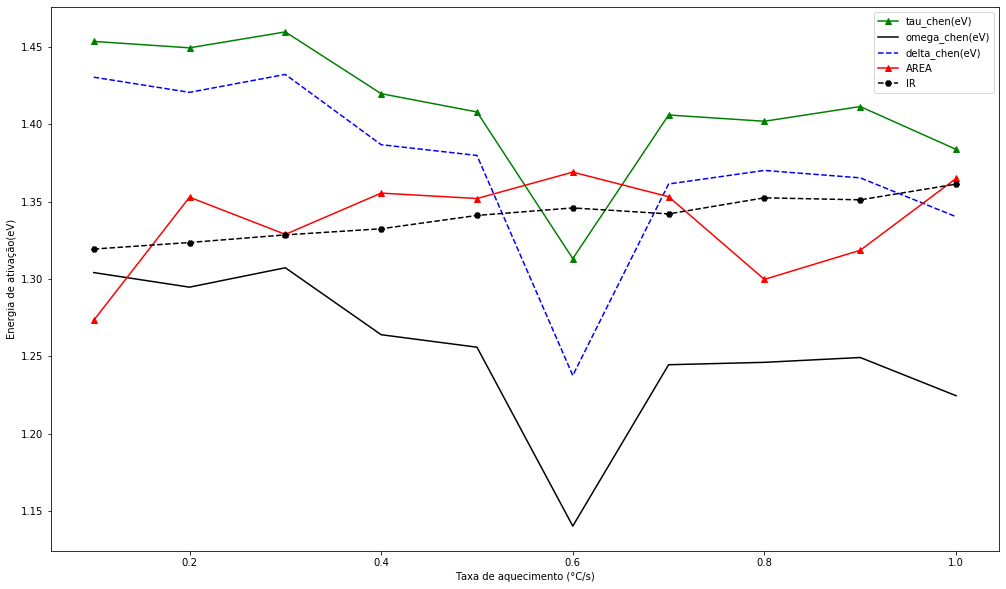

In [40]:
import matplotlib.pyplot as plt
i = ['tau_chen(eV)','omega_chen(eV)','delta_chen(eV)']
cor = ['^g-','k-','b--']
Fig1=plt.Figure(figsize=(17,10)); ax = Fig1.add_subplot(1,1,1)
for isa,color in zip(i,cor):
    ax.plot(grupo1.index, grupo1[isa], color, label= isa)
ax.plot(grupo1.index, grupo2['EA_AREA(eV)'], '^r-', label= 'AREA')
ax.plot(grupo1.index, grupo3['EA_IR(eV)'], 'Hk--', label= 'IR')
ax.legend(loc='best')
ax.set_ylabel('Energia de ativação(eV)')
ax.set_xlabel('Taxa de aquecimento (°C/s)')
Fig1.savefig('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Resultados finais/E(beta0.1-1)KORR.png')
Fig1

In [44]:
arquivo.extract_pshape()

,tau_chen(eV),omega_chen(eV),delta_chen(eV),delta_error,ordem_cinetica,tmax,t1,t2,IM,Shape_factor,Sf_error,objeto
Curva 11,1.327856,1.192679,1.323734,0.044124,Primeira Ordem,480,459,496,1386298.0,0.432432,0.019357,Curva 11
Curva 12,1.294808,1.151332,1.277237,0.042515,Primeira Ordem,491,469,507,1451281.0,0.421053,0.018698,Curva 12
Curva 13,1.212933,1.079554,1.200390,0.040034,Primeira Ordem,476,454,492,1462620.0,0.421053,0.018698,Curva 13
Curva 14,1.217653,1.069988,1.184497,0.039418,Primeira Ordem,493,470,509,1353010.0,0.410256,0.018080,Curva 14
Curva 15,1.386632,1.244651,1.379464,0.045923,Primeira Ordem,490,469,506,1237053.0,0.432432,0.019357,Curva 15
...,...,...,...,...,...,...,...,...,...,...,...,...
Curva 191,1.339371,1.207363,1.326431,0.058584,Ordem Geral,400,385,412,1721279.0,0.444444,0.026749,Curva 191
Curva 192,1.353381,1.219813,1.339728,0.059155,Ordem Geral,402,387,414,1916845.0,0.444444,0.026749,Curva 192
Curva 193,1.211971,1.082056,1.193295,0.052704,Primeira Ordem,400,384,412,2046386.0,0.428571,0.025510,Curva 193
Curva 194,1.277020,1.155576,1.272943,0.052118,Ordem Geral,403,387,416,1795931.0,0.448276,0.024970,Curva 194


In [37]:
area.max()

EA_AREA(eV)                1.48586
error_AREA               0.0273048
r^2_AREA                 -0.974546
freq_factor_AREA        8.3852e-12
ff_err_AREA            5.51057e-12
ff_percerr_AREA           0.657178
AREA_kin_order               b = 1
objeto                    Curva 95
Taxa de aquecimento             10
dtype: object

In [134]:
class Lumia():
    
    def __init__(self, dados={},pre_heat=False):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        self.data = dados
        self.pre_heat = pre_heat
    #_______________________________________________________________________________________________________________

    def load_TL(self, arquivo,pre_heat=False, pre_heat_value=25, points_equal_temp=True,trimm_by='\t', lim_init = 4):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        with open(arquivo, 'r') as f:#Abre arquivo
            matrix = [[item for item in line.split(trimm_by)] for line in f.readlines()[lim_init:-1]]#Quebra linhas e colunas por tabulação
        matrixNumpy = np.array(matrix)                #matriz numpy
        curve={}                                     #variavel dicionario auxiliar
        for i in range(len(matrixNumpy.T)):       #É a iteração nas colunas pelo intervalo da matrix transposta do resultado
            lab=matrixNumpy[:,i]               #seleciona a coluna toda
            lista=[]                         #lista auxiliar
            for lin in lab:                   #iteração de valor em valor
                try:                         #evita bugs e erros por conversão falha
                    lista.append(int(lin))      #converte str para int
                except:
                    lista.append(np.nan)      #caso vazio e erro adiciona NAN
            if i == 0:                        #a primeira coluna é temperatura
                if pre_heat == False:          #Teste logico de preheat para soma de Temperatura inicial
                    curve.setdefault('Temperatura',lista) #Adciona o rótulo temperatura ao dicionario
                else:
                    lista = np.array(lista) + pre_heat_value #soma o preheat em um nd array
                    lista = list(lista)
                    curve.setdefault('Temperatura',lista) #adiciona a temperatura ao dicinario
            else:
                curve.setdefault('Curva {0}'.format(i),lista) #Adiciona as curvas ao dicionario
        data=pd.DataFrame(curve, index=curve['Temperatura']) #cria um pd.dataframe com os resultados
        self.data = data
        return data
    
        #_______________________________________________________________________________________________________________
    def add_data(self,arquivo):
        self.data = arquivo
        
         #______________________________________________________________________________________________________________
    def init_rise_prep(curva,lim_init=80,lim_fin=250,sig=0.07, pre_heat=False, npontos=13, pre_heat_val=25):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt

    #variaveis importantes    
        k=0.00008617333262145                       #constante de bolzmann
                 #Diminuição do dataframe
        curva1 = curva[lim_init:lim_fin]            #Fatia o dataframe no intervalo de interesse
        limite = curva1.cumsum()                        #Determinação dos limites
        tol = limite[max(limite.index)]*sig            #Tolerância para seção do dataset
        atol = []                                     #lista vazia a ser preenchida com valores de intensidade TL
        index = []                                   #índice padrão
        temp = []                                  #temperatura em kelvin
    
        for it,num,cur in zip(limite,limite.index,curva1):
            if it < tol:
                atol.append(cur)
                temp.append(num+273)
                index.append(num)
        if pre_heat == True:
            temp = np.array(temp) + pre_heat_val
        else:
            pass 
        lim_temp = max(index)
        int_val = lim_temp - npontos #Seleciona 14 pontos
        diff = int_val-lim_init 
        Frame = pd.DataFrame()
        Frame['Temperatura (K)'] = temp
        Frame['TL'] = atol
        Frame['ln(TL)'] = np.log(atol)
        Frame['1/kt'] = 1/(k*Frame['Temperatura (K)'])
        Frame.index=index
        Frame= Frame[:][diff:]
        return Frame
    
        #_______________________________________________________________________________________________________________

    def init_rise_result(prepared_data):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        x = np.array(prepared_data['1/kt'])
        y = np.array(prepared_data['ln(TL)'])
        from scipy.stats import linregress
        lin_reg = linregress(x,y)
        ea = -1*lin_reg.slope
        answer = {'Parametros present':{'Energia de Ativação':'{0}  ± {1} eV'.format(ea, lin_reg.stderr),'r^2':lin_reg.rvalue},
                 'Parametros Calc':{'Energia de Ativação':ea,'incerteza':lin_reg.stderr}}
    
        answerdb = {'Energia de Ativação':ea,'incerteza':lin_reg.stderr, 'r^2':lin_reg.rvalue}
        return answerdb
    
        #_______________________________________________________________________________________________________________

    def extract_ir(self):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        pre_heat = self.pre_heat
        resposta = {'EA_IR(eV)':[],'error_ir':[],'r^2_ir':[],'objeto':[]}#conjunto resposta
        colunas = list(self.data.columns)
        colunas = colunas[1:]
        for coluna in colunas:
            dados = Lumia.init_rise_prep(curva=self.data[coluna],pre_heat=pre_heat)                #função de preparação
            answer = Lumia.init_rise_result(dados)                    #função de regressão
            resposta['EA_IR(eV)'] += [answer['Energia de Ativação']]#adição da resposta
            resposta['error_ir'] += [answer['incerteza']]       #adição da resposta
            resposta['r^2_ir'] += [answer['r^2']]               #adição da resposta
            resposta['objeto'] += [coluna]                      #adição da resposta
        return pd.DataFrame(resposta,index=resposta['objeto'])
    
    #_______________________________________________________________________________________________________________
    def area_met_prep(curva,heat_rate, kin_order, lim_init=80,lim_fin=150,deltaT=1, pre_heat=False):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        if heat_rate > 6:
            lim_init=135 
            lim_fin=240 
        elif heat_rate ==6:
            lim_init=120
            lim_fin=220
        elif heat_rate == 5:
            lim_init=120
            lim_fin=220
        elif (heat_rate < 5) & (heat_rate>2):
            lim_init= 130
            lim_fin=  210
        elif heat_rate == 2:
            lim_init= 100
            lim_fin=  200
        elif heat_rate == 1:
            lim_init= 95
            lim_fin=  185
        elif heat_rate == 0.9:
            lim_init=95
            lim_fin= 190
        elif heat_rate == 0.8:
            lim_init=95
            lim_fin= 190
        elif heat_rate == 0.7:
            lim_init=90
            lim_fin=180
        elif (heat_rate < 0.7) & (heat_rate > 0.4):
            lim_init=90
            lim_fin=175
        elif (heat_rate == 0.4):
            lim_init=85
            lim_fin=170
        elif (heat_rate == 0.3):
            lim_init=85
            lim_fin=170
        
        elif (heat_rate == 0.2) | (heat_rate == 0.1):
            lim_init=80
            lim_fin=160
        k=0.00008617333262145
        y = np.array(curva[lim_init:lim_fin])
        x = np.array(curva[lim_init:lim_fin].index)
        temp = x+273     #converte a temperatura para kelvin
        preview = pd.DataFrame()
        if pre_heat == True:
            temp+=25
        else:
            pass
        preview['Temperatura (K)'] = temp
        preview['TL'] = y
        preview.set_index(x, inplace=True)
        area=[]
        for i in range(len(y)):
            area.append((max(y[i:len(y)].cumsum()))*(deltaT/heat_rate))
        np.array(area)
        preview['area'] = area
        preview['1/kt'] =  1/(k*preview['Temperatura (K)'])
        preview['ln(TL/area)'] = np.log(preview.TL/preview.area)
        for ko in kin_order:
            pr = np.array(np.log(preview.TL/(preview.area)**ko))
            preview = dict(preview)
            preview.setdefault('b= {0}'.format(ko), pr)
            preview = pd.DataFrame(preview)
        return preview
    
        #_______________________________________________________________________________________________________________

    def area_result(prepared_data, heat_rate):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        import math
        from scipy.stats import linregress
    
        x = np.array(prepared_data['1/kt'])
        atr_list = list(prepared_data.columns)
        atr_list = atr_list[4:]
        r_squared = {}
    
        for atributo in atr_list:
            y=np.array(prepared_data[atributo])
            lin_reg = linregress(x,y)
            r_squared.setdefault(atributo,-1*lin_reg.rvalue)
        best = max(r_squared)
        y=np.array(prepared_data[best])
        lin_reg = linregress(x,y)
        ea = -1*lin_reg.slope
        escape_factor = heat_rate*math.exp(-lin_reg.intercept)
        escape_error = lin_reg.intercept_stderr * escape_factor
        percentual_error = escape_error/escape_factor
        if best == 'ln(TL/area)':
            best = 'b = 1'
        answer_present = {'Energia de Ativação':'{0}  ± {1} eV'.format(ea, lin_reg.stderr),
                      'r^2':lin_reg.rvalue,
                      'Fator de Escape':'{0} ± {1} eV'.format(escape_factor,escape_error),
                      'Erro percentual':'{0} %'.format(percentual_error*100)}
        answer_db = {'Energia de Ativação':ea,
                 'Incerteza EA':lin_reg.stderr,
                 'r^2':lin_reg.rvalue,
                 'Fator de Escape':escape_factor, 
                 'Incerteza Escape_factor':escape_error,
                 'Percentual Error':percentual_error,
                 'Best_kin_order':best}                       
        return answer_present, answer_db
    
        #_______________________________________________________________________________________________________________

    def extract_area(self,heat_rate,test_kin_order):#informar uma lista com todas as taxas de aquecimento do DB
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        pre_heat = self.pre_heat
        resposta = {'EA_AREA(eV)':[],'error_AREA':[],'r^2_AREA':[],'freq_factor_AREA':[],
                    'ff_err_AREA':[],'ff_percerr_AREA':[],'AREA_kin_order':[],'objeto':[], 
                    'Taxa de aquecimento':[]} #conjunto resposta
        colunas = list(self.data.columns)
        colunas = colunas[1:]
        for coluna, hr in zip(colunas, heat_rate):
            dados = Lumia.area_met_prep(self.data[coluna],hr, test_kin_order, pre_heat=pre_heat)                #função de preparação
            answer_pres, answer = Lumia.area_result(dados,hr)                    #função de regressão
            resposta['EA_AREA(eV)'] += [answer['Energia de Ativação']]#adição da resposta
            resposta['error_AREA'] += [answer['Incerteza EA']]       #adição da resposta
            resposta['r^2_AREA'] += [answer['r^2']]               #adição da resposta
            resposta['freq_factor_AREA'] += [answer['Fator de Escape']]
            resposta['ff_err_AREA'] += [answer['Incerteza Escape_factor']]
            resposta['ff_percerr_AREA'] += [answer['Percentual Error']]
            resposta['AREA_kin_order'] += [answer['Best_kin_order']]
            resposta['Taxa de aquecimento'] += [hr]
            resposta['objeto'] += [coluna]                      #adição da resposta
        return pd.DataFrame(resposta,index=resposta['objeto'])
    
    #_______________________________________________________________________________________________________________

    def peak_shape_met(curva,DeltaT=1,error=0.5, ph_val=25, pre_heat=False):
    #Encontrar a posição do pico
        peak = curva.max()

    #Encontrar o índice (Temperatura) do pico:

        j=0
        for i in curva:
            if i == peak:
                tmax = j*DeltaT
                break
            else:
                j+=1

    #Meia Altura
        half_peak = peak/2
    #Divisão do Dataset em dois
        t1_cand = np.array(curva[:tmax]) #Para T1
        t2_cand = np.array(curva[tmax:]) #Para T2

    #################################################################################################################

    #Testes lógicos para encontrar os índex respectivos
    # Fração inferior ao pico
        j=0
        for cand1 in t1_cand:
            if cand1 < half_peak:
                j0=j
                j+=1
            else:
                j2 = j0+1
                j+= 1
                continue
    # O j não reseta entre as iterações de t1_cand para t2_cand

    # Fração superior ao pico
        for cand2 in t2_cand:
            if cand2 > half_peak:
                j1=j
                j+=1
            else:
                j3 = j1+1
                break

    #Obtenção de T1 e transformação de ponto para temperatura
        if (half_peak - curva[j0]) < (curva[j2] - half_peak):
            t1 = j0 * DeltaT
        else:
            t1 = j2 * DeltaT
    #Obtenção de T2  
        if (curva[j1] - half_peak) < (half_peak - curva[j3]):
            t2 = j1 * DeltaT
        else:
            t2 = j3 * DeltaT
    ########################################################################################################################    

    # para kelvin
        t1 += 273
        t2 += 273
        tmax += 273
        k=0.00008617333262145
        
        if pre_heat == True:
            t1 += ph_val
            t2 += ph_val
            tmax += ph_val
        else:
            pass
    # Calculo dos parâmetros de forma
        delta = t2 - tmax
        omega = t2 - t1
        tau = tmax - t1
        shape_factor_mi = delta/omega
        shape_factor_gama = delta/tau

    #Energia de ativação

    #Omega de Chen
        omega_chen = (2.25+10.2*(shape_factor_mi - 0.42))*((k*tmax**2)/omega) - 1*(2*k*tmax)
    #Tau de Chen
        tau_chen = (1.510+3.0*(shape_factor_mi - 0.42))*((k*tmax**2)/tau) - (1.58+4.2*(shape_factor_mi - 0.42))*(2*k*tmax)
    #delta de Chen
        delta_chen = (0.976+7.3*(shape_factor_mi - 0.42))*((k*tmax**2)/delta)
    #kinetic order
        if shape_factor_mi < 0.44:
            kin_order = 'Primeira Ordem'
        elif shape_factor_mi < 0.50:
            kin_order = 'Ordem Geral'
        else:
            kin_order = 'Segunda Ordem'
    #Incertezas
    #delta
        delta_error = (2*(error/tmax) + (error/delta))*delta_chen
        mi_error = ((error/delta) + (error/omega))*shape_factor_mi
    #resposta
        answer = {'Parâmetros de forma':{'delta':'{0} K'.format(delta),'omega':'{0} K'.format(omega),'tau':'{0} K'.format(tau),
                                         'mi':'{0} ± {1}'.format(shape_factor_mi, mi_error)},
                  'Energia de Ativação':{'Delta de Chen':'{0} ± {1} eV'.format(delta_chen,delta_error),
                                         'Tau de Chen':'{0} eV'.format(tau_chen),
                                         'Omega de Chen':'{0} eV'.format(omega_chen)},
                  'Ordem Cinética':kin_order, 'Outras informações':{'TMax':'{0} K'.format(tmax),'T1':'{0} K'.format(t1),
                                                                'T2':'{0} K'.format(t2), 'IM':peak}}
        answerdb = {'Delta de Chen':delta_chen,
                    'deta_error':delta_error,
                    'Tau de Chen':tau_chen,
                    'Omega de Chen':omega_chen,
                    'Ordem Cinética':kin_order,
                    'Tmax':tmax,
                    'T1':t1,
                    'T2':t2,
                    'IM':peak,
                    'Mi':shape_factor_mi,
                    'mi_error':mi_error,
                    'delta':delta,
                    'Tau':tau,
                    'Omega':omega}
        return answer, answerdb
    
    #_______________________________________________________________________________________________________________
    def extract_pshape(self):
        pre_heat = self.pre_heat
        resposta = {'tau_chen(eV)':[],'omega_chen(eV)':[],'delta_chen(eV)':[],'delta_error':[],
                    'ordem_cinetica':[],'tmax':[],'t1':[],'t2':[],'IM':[],'Shape_factor':[],
                    'Sf_error':[],'objeto':[]} #conjunto resposta
        colunas = list(self.data.columns)
        colunas = colunas[1:]
        for coluna in colunas:              
            answer_pres, answer = Lumia.peak_shape_met(self.data[coluna],pre_heat=pre_heat)                    #função de regressão
            resposta['tau_chen(eV)'] += [answer['Tau de Chen']]#adição da resposta
            resposta['omega_chen(eV)'] += [answer['Omega de Chen']]       #adição da resposta
            resposta['delta_chen(eV)'] += [answer['Delta de Chen']]               #adição da resposta
            resposta['delta_error'] += [answer['deta_error']]       
            resposta['ordem_cinetica'] += [answer['Ordem Cinética']]          
            resposta['tmax'] += [answer['Tmax']]          
            resposta['t1'] += [answer['T1']]          
            resposta['t2'] += [answer['T2']]
            resposta['IM'] += [answer['IM']]
            resposta['Shape_factor'] += [answer['Mi']]
            resposta['Sf_error'] += [answer['mi_error']]
            resposta['objeto'] += [coluna]                      #adição da resposta
        return pd.DataFrame(resposta,index=resposta['objeto'])
    
     #_______________________________________________________________________________________________________________
    
    def multi_heating_rate_ti(curva1,curva2,heating_rate, DeltaT=1):
        pre_heat = self.pre_heat
    #Encontrar a posição do pico
        if pre_heat == True:
            pre_heat_temp=25
        else:
            pre_heat_temp=0
        k=0.00008617333262145
        curvas = [curva1,curva2] #transforma em um objeto tipo lista iteravel
        ind=0 # quando ind=0, sub index 1, quando ind=1 sub index 2
#Encontrar IM & TM de cada uma das curvas:
        for curva, hr in zip(curvas, heating_rate):
            peak = curva.max()
            j=0
            for i in curva:
                if i == peak:
                    tmax = j*DeltaT + pre_heat_temp
                    break
                else:
                    j+=1
            if ind == 0:
                tm1c = tmax
                Im1s = peak
                hr_1 = hr
                Im1 = peak/hr_1
                Tm1 = tm1c+ 273
             
            else:
                tm2c = tmax
                hr_2= hr
                Im2 = peak/hr_2
                Tm2 = tm2c + 273
            ind+=1
    #Calculo da Energia de ativação
        EA_beta = k * ((Tm1*Tm2)/(Tm1-Tm2))*np.log((hr_1/hr_2)*(Tm1/Tm2)**2)
        EA_Im = ((k*Tm1*Tm2)/(Tm1-Tm2))*np.log((Im1/Im2))
        return(EA_beta,EA_Im,Tm1,Tm2)

    #_______________________________________________________________________________________________________________
    def multi_heating_rate_prep(dataset,curvas,heating_rate, DeltaT=1,ph_val=25, pre_heat=False): 
        Df_new = {'Temperatura (C)':[], 'Temperatura (K)':[],'y':[],'x':[],'Heat_rate':[]}
        k=0.00008617333262145
        for curv, hr in zip(curvas, heating_rate):
            curva = dataset[curv]
            peak = curva.max()
            j=0
            for i in curva:
                if i == peak:
                    tmax = j*DeltaT
                    break
                else:
                    j+=1
            if pre_heat==True:
                tm1c = tmax+ph_val
            else:
                tm1c = tmax
            Tm = tm1c+ 273
            
            Df_new['Temperatura (C)'] += [tm1c]
            Df_new['Temperatura (K)'] += [Tm]
            Df_new['y'] += [np.log((Tm**2)/hr)]
            Df_new['x'] += [1/(k*Tm)]
            Df_new['Heat_rate'] += [hr]
        return pd.DataFrame(Df_new)

    #_______________________________________________________________________________________________________________
    def multi_heating_rate_reg(dados_preparados):#recebe a saída de multi_heating_rate_prep()
        from scipy.stats import linregress
        import math
        k=0.00008617333262145
        x = dados_preparados['x']
        y = dados_preparados['y']
    #Regressão Linear

        lin_reg = linregress(x,y) #Regressão
    
    #Calculo de parâmetros cinéticos

        ea = lin_reg.slope
        intercept = lin_reg.intercept
        escape_factor = ea*math.exp(intercept/k)
        escape_per_error = (lin_reg.stderr/ea) + lin_reg.intercept_stderr
        escape_error = escape_per_error * escape_factor
    
    #Resposta   
        answer_present = {'Energia de Ativação':'{0}  ± {1} eV'.format(ea, lin_reg.stderr),
                            'r^2':lin_reg.rvalue,
                          'Fator de Escape':'{0} ± {1} eV'.format(escape_factor,escape_error),
                          'Erro percentual':'{0} %'.format(escape_per_error*100)}
        answer_db = {'Energia de Ativação':ea,
                     'Incerteza EA':lin_reg.stderr,
                     'r^2':lin_reg.rvalue,
                     'Fator de Escape':escape_factor, 
                     'Incerteza Escape_factor':escape_error,
                     'Percentual Error':escape_per_error} 
        return answer_present, answer_db
    #_______________________________________________________________________________________________________________

#Entra com o conjunto de dados e uma lista com a lista de nomes das curvas de cada amostra
    def extract_mhr(self,samples,heat_rate, pre_heat=False):#informar uma lista com todas as taxas de aquecimento do DB
        resposta = {'EA_mhr(eV)':[],'error_mhr':[],'r^2_mp':[],'freq_factor_mp':[],
                    'ff_percerr_mp':[],'Amostra':[] 
                    } #conjunto resposta
        amostra = 1
        for sample in samples:
        
            dados = Lumia.multi_heating_rate_prep(self.data,sample,heat_rate)               #função de preparação
            answer_pres, answer = multi_heating_rate_reg(dados)                    #função de regressão
            resposta['EA_mhr(eV)'] += [answer['Energia de Ativação']]#adição da resposta
            resposta['error_mhr'] += [answer['Incerteza EA']]       #adição da resposta
            resposta['r^2_mp'] += [answer['r^2']]               #adição da resposta
            resposta['freq_factor_mp'] += [answer['Fator de Escape']]
            resposta['ff_percerr_mp'] += [answer['Percentual Error']]
            resposta['Amostra'] += ['Amosta {0}'.format(amostra)]                      #adição da resposta
            amostra+=1
        return pd.DataFrame(resposta, index=resposta['Amostra'])


In [254]:
arquivo3=Lumia(dados,pre_heat=True)

In [255]:
arquivo3.extract_area(heat_rate,[1.1,1.2,1.3])

,EA_AREA(eV),error_AREA,r^2_AREA,freq_factor_AREA,ff_err_AREA,ff_percerr_AREA,AREA_kin_order,objeto,Taxa de aquecimento
Curva 11,1.451286,0.008010,-0.998435,5.180200e-14,9.986576e-15,0.192784,b = 1,Curva 11,10.0
Curva 12,1.446617,0.018910,-0.991314,1.073656e-13,4.886562e-14,0.455133,b = 1,Curva 12,10.0
Curva 13,1.423597,0.005501,-0.999232,7.637211e-14,1.011197e-14,0.132404,b = 1,Curva 13,10.0
Curva 14,1.474031,0.018264,-0.992186,6.309426e-14,2.773469e-14,0.439575,b = 1,Curva 14,10.0
Curva 15,1.479157,0.016853,-0.993381,4.914216e-14,1.993328e-14,0.405625,b = 1,Curva 15,10.0
...,...,...,...,...,...,...,...,...,...
Curva 191,1.256808,0.011098,-0.996973,1.869090e-14,5.792140e-15,0.309891,b = 1,Curva 191,0.1
Curva 192,1.285747,0.007467,-0.998687,9.753456e-15,2.033614e-15,0.208502,b = 1,Curva 192,0.1
Curva 193,1.255140,0.011505,-0.996739,1.928593e-14,6.195672e-15,0.321253,b = 1,Curva 193,0.1
Curva 194,1.289269,0.007122,-0.998812,9.663769e-15,1.921903e-15,0.198877,b = 1,Curva 194,0.1


In [247]:
arquivo3.extract_pshape()

,tau_chen(eV),omega_chen(eV),delta_chen(eV),delta_error,ordem_cinetica,tmax,t1,t2,IM,Shape_factor,Sf_error,objeto
Curva 11,1.327856,1.192679,1.323734,0.044124,Primeira Ordem,480,459,496,1386298.0,0.432432,0.019357,Curva 11
Curva 12,1.294808,1.151332,1.277237,0.042515,Primeira Ordem,491,469,507,1451281.0,0.421053,0.018698,Curva 12
Curva 13,1.212933,1.079554,1.200390,0.040034,Primeira Ordem,476,454,492,1462620.0,0.421053,0.018698,Curva 13
Curva 14,1.217653,1.069988,1.184497,0.039418,Primeira Ordem,493,470,509,1353010.0,0.410256,0.018080,Curva 14
Curva 15,1.386632,1.244651,1.379464,0.045923,Primeira Ordem,490,469,506,1237053.0,0.432432,0.019357,Curva 15
...,...,...,...,...,...,...,...,...,...,...,...,...
Curva 191,1.339371,1.207363,1.326431,0.058584,Ordem Geral,400,385,412,1721279.0,0.444444,0.026749,Curva 191
Curva 192,1.353381,1.219813,1.339728,0.059155,Ordem Geral,402,387,414,1916845.0,0.444444,0.026749,Curva 192
Curva 193,1.211971,1.082056,1.193295,0.052704,Primeira Ordem,400,384,412,2046386.0,0.428571,0.025510,Curva 193
Curva 194,1.277020,1.155576,1.272943,0.052118,Ordem Geral,403,387,416,1795931.0,0.448276,0.024970,Curva 194


In [256]:
arquivo3.extract_ir()

,EA_IR(eV),error_ir,r^2_ir,objeto
Curva 11,1.513540,0.005292,-0.999927,Curva 11
Curva 12,1.539859,0.006485,-0.999894,Curva 12
Curva 13,1.483274,0.003084,-0.999974,Curva 13
Curva 14,1.535073,0.003688,-0.999965,Curva 14
Curva 15,1.543949,0.005432,-0.999926,Curva 15
...,...,...,...,...
Curva 191,1.323269,0.002544,-0.999978,Curva 191
Curva 192,1.314336,0.002844,-0.999972,Curva 192
Curva 193,1.330718,0.003914,-0.999948,Curva 193
Curva 194,1.315803,0.002249,-0.999982,Curva 194
